<a href="https://colab.research.google.com/github/lzanaghi/Bank-Clients-Churn-Prediction/blob/main/BankClientsChurnPredictionClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Carregar o dataset
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Atributos:

* RowNumber - Número da linha
* CustomerId - Identificador do Cliente
* Surname - Sobrenome
* CreditScore - Pontuação de crédito
* Geography - País do Cliente
* Gender - Gênero
* Age - Idade
* Tenure - O número de meses ou anos que o cliente mantém o serviço.
* Balance - Saldo
* NumOfProducts - Número de produtos
* HasCrCard - Se o cliente tem ou não cartão de crédito
* IsActiveMember - Se o cliente é um membro ativo
* Estimated Salary - Salário estimado
* Exited - Se o cliente cancelou ou não o vínculo com o banco





---



**ANÁLISE EXPLORTÓRIA DE DADOS**

In [2]:
# Verificar valores nulos antes do preenchimento
print("Valores nulos antes do preenchimento:")
print(df.isnull().sum())

Valores nulos antes do preenchimento:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Não tem valores nulos no dataset



---



Procurar por linhas duplicadas

In [3]:
duplicate_counts = df.groupby(df.columns.tolist()).size().reset_index(name='Count')

# Filtrar para mostrar apenas as linhas que têm duplicatas
duplicates_only = duplicate_counts[duplicate_counts['Count'] > 1]

# Exibir os resultados
print(duplicates_only)

Empty DataFrame
Columns: [RowNumber, CustomerId, Surname, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited, Count]
Index: []


Não tem valores duplicados no dataset



---



Busca de alguma relação entre a variável alvo e os demais atributos

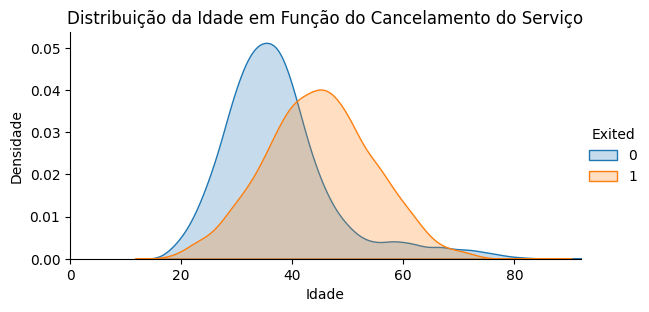

In [4]:
facet = sns.FacetGrid(df, hue="Exited",aspect=2)
facet.map(sns.kdeplot,"Age",fill= True)
facet.set(xlim=(0, df["Age"].max()))
facet.add_legend()

plt.title("Distribuição da Idade em Função do Cancelamento do Serviço")
plt.xlabel("Idade")
plt.ylabel("Densidade")
plt.show()

Pessoas na faixa de (aproximadamente) 40 até 70 anos são mais propensas a cancelarem o serviço.



---



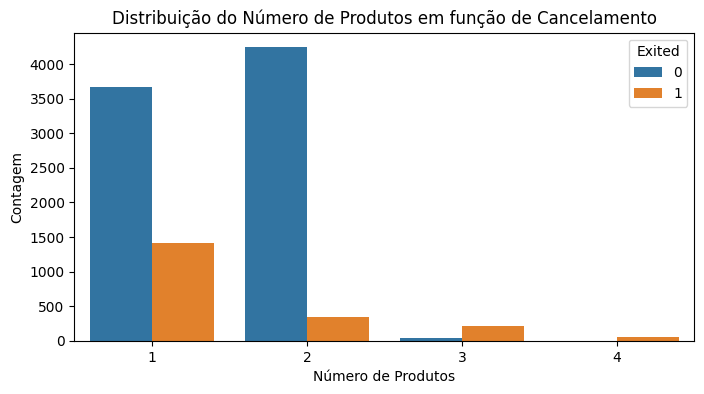

In [5]:
_, ax = plt.subplots(1, figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)

sns.countplot(x="NumOfProducts", hue="Exited", data=df, ax=ax)

ax.set_title('Distribuição do Número de Produtos em função de Cancelamento')
ax.set_xlabel('Número de Produtos')
ax.set_ylabel('Contagem')

plt.show()


É perceptível que NumOfProducts tem um forte relação com os clientes que cancelaram

In [6]:
df[['NumOfProducts', 'Exited']].groupby(['NumOfProducts'], as_index=False).mean().sort_values(by='Exited', ascending=False)

,NumOfProducts,Exited
3,4,1.000000
2,3,0.827068
0,1,0.277144
1,2,0.075817




---



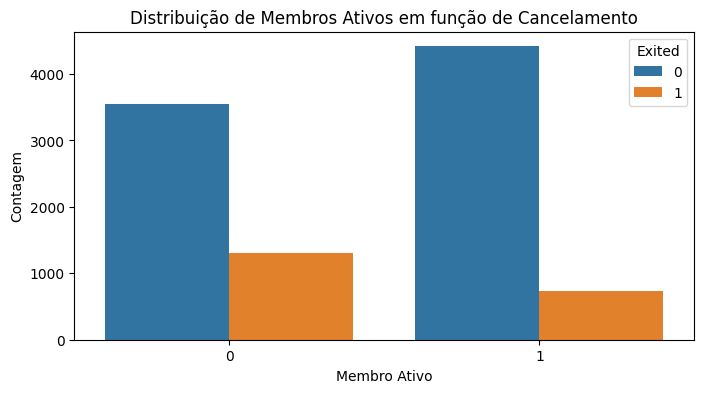

In [7]:
_, ax = plt.subplots(1, figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)

sns.countplot(x="IsActiveMember", hue="Exited", data=df, ax=ax)

ax.set_title('Distribuição de Membros Ativos em função de Cancelamento')
ax.set_xlabel('Membro Ativo')
ax.set_ylabel('Contagem')

plt.show()

Se o membro é ativo(1), tem menos chance de cancelar. Se o membro não é ativo(0), tem mais chance de cancelar

In [8]:
df[['IsActiveMember', 'Exited']].groupby(['IsActiveMember'], as_index=False).mean().sort_values(by='Exited', ascending=False)

,IsActiveMember,Exited
0,0,0.268509
1,1,0.142691




---



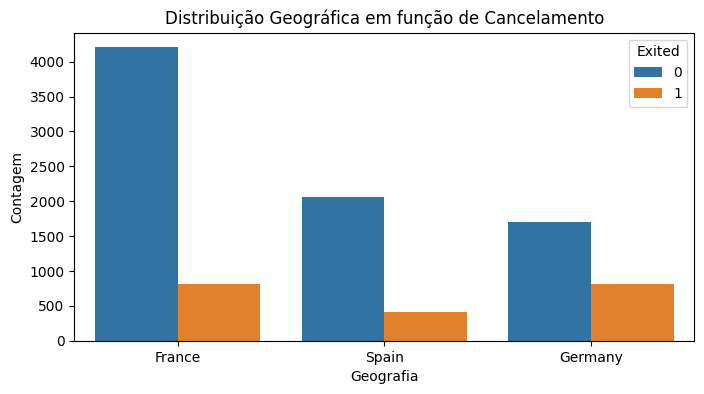

In [9]:
_, ax = plt.subplots(1, figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)

sns.countplot(x="Geography", hue="Exited", data=df, ax=ax)

ax.set_title('Distribuição Geográfica em função de Cancelamento')
ax.set_xlabel('Geografia')
ax.set_ylabel('Contagem')

plt.show()

Se for da Alemanha é bastante provável que cancele

1.   Se a pessoa é da França é provável que não cancele.
2.   Se a pessoa for da Alemanha é bastante provável que cancele.





---



<ipython-input-10-97345fb71eaa>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_gender, x='Gender', y='Exited', palette={'Male': 'lightblue', 'Female': 'lightcoral'})


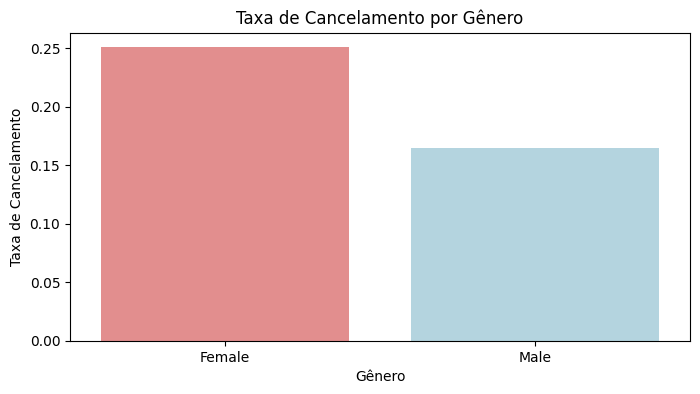

In [10]:
churn_by_gender = df.copy()

# Agrupamento e cálculo da taxa de cancelamento
churn_by_gender = churn_by_gender.groupby('Gender')['Exited'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=churn_by_gender, x='Gender', y='Exited', palette={'Male': 'lightblue', 'Female': 'lightcoral'})

plt.title('Taxa de Cancelamento por Gênero')
plt.xlabel('Gênero')
plt.ylabel('Taxa de Cancelamento')

plt.show()

Homens tem menos chance de cancelar e mulheres tem mais chance de cancelar, de acordo com o dataset.

O número de homens e mulheres é bem parelho no dataset

In [11]:
gender_counts = df['Gender'].value_counts()
print(gender_counts)

Gender
Male      5457
Female    4543
Name: count, dtype: int64


In [12]:
df[['Gender', 'Exited']].groupby(['Gender'], as_index=False).mean().sort_values(by='Exited', ascending=False)

,Gender,Exited
0,Female,0.250715
1,Male,0.164559




---



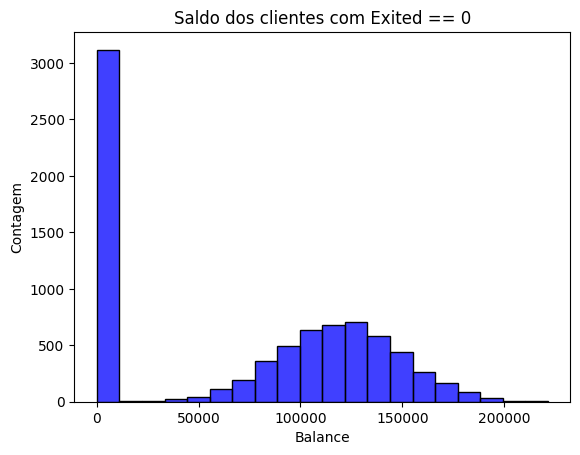

In [13]:
df_exited_1 = df[df['Exited'] == 0]

# Cria o gráfico apenas para Exited == 1
sns.histplot(df_exited_1['Balance'], bins=20, color='blue')

plt.title('Saldo dos clientes com Exited == 0')
plt.xlabel('Balance')
plt.ylabel('Contagem')

plt.show()

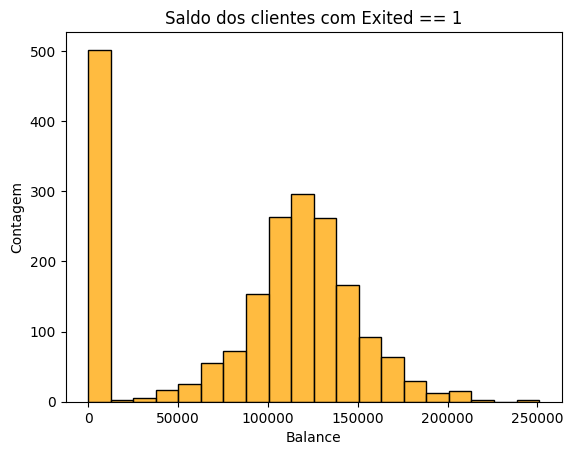

In [14]:
df_exited_1 = df[df['Exited'] == 1]

# Cria o gráfico apenas para Exited == 1
sns.histplot(df_exited_1['Balance'], bins=20, color='orange')

plt.title('Saldo dos clientes com Exited == 1')
plt.xlabel('Balance')
plt.ylabel('Contagem')

plt.show()

Pessoas com saldo zero são menos propensas a cancelar



---



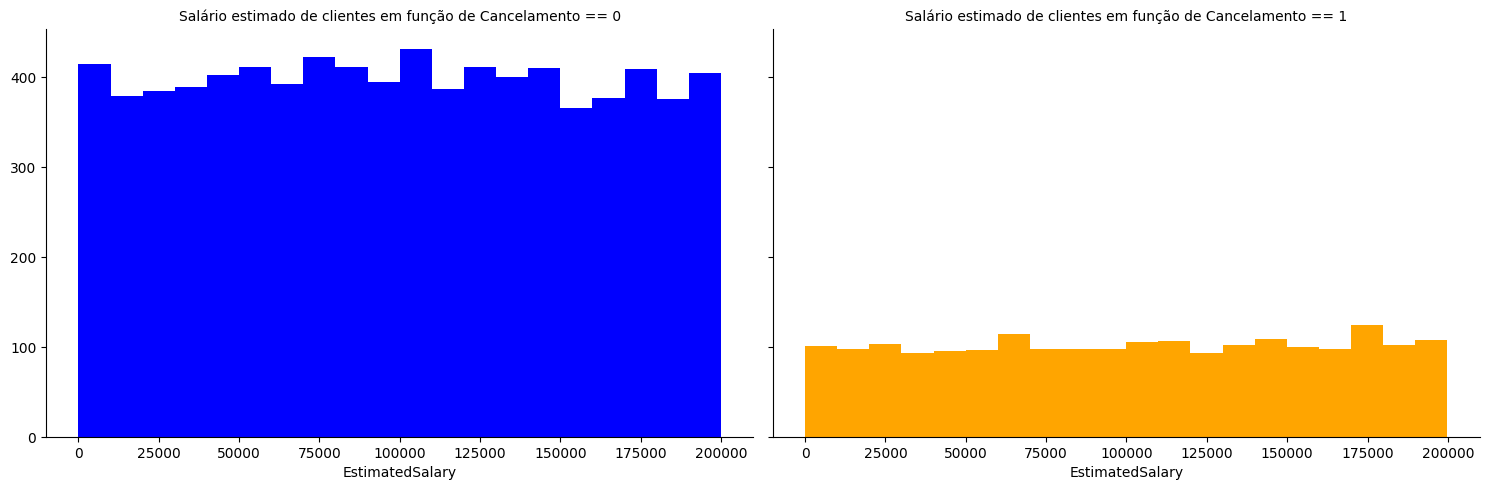

In [15]:
g = sns.FacetGrid(df, col='Exited', height=5, aspect=1.5)

g.map(plt.hist, 'EstimatedSalary', bins=20, color='gray')

colors = ['blue', 'orange']

for ax, color in zip(g.axes.flatten(), colors):
    for patch in ax.patches:
        patch.set_facecolor(color)

g.set_titles(col_template="Salário estimado de clientes em função de Cancelamento == {col_name}")

plt.show()

O salário estimado não é tão interessante para o modelo, pois não tem nenhuma correlação com o numero de pessoas que cancelaram. Ambos gráficos estão bem equilibrados. O mesmo vale para todas outras colunas retiradas do dataset.

**PRÉ-PROCESSAMENTO DE DADOS**

Balanceamento entre as classes

In [16]:
df_majority = df[df['Exited'] == 0]  # Classe majoritária
df_minority = df[df['Exited'] == 1]  # Classe minoritária

# Pega o número de amostras da classe minoritária
n_minority_samples = len(df_minority)

# Realizar o undersampling da classe majoritária para ter o mesmo número de amostras que a classe minoritária
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # Sem duplicação
                                   n_samples=n_minority_samples,  # Número de amostras igual ao da classe minoritária
                                   random_state=42)

# Combinar novamente o dataset com a classe minoritária inalterada
df = pd.concat([df_minority, df_majority_downsampled])



---



Deletar colunas irrelevantes

In [17]:
df.drop(columns=['CustomerId','RowNumber', 'Surname'],inplace=True)



---



Codificar variáveis categóricas

In [18]:
df['Geography'] = df.Geography.map({"France":0, "Spain":1, "Germany":2})
df['Gender'] = df.Gender.map({"Male":0, "Female":1})



---





---



**TREINO**

Treino Naive Bayes

In [19]:
#deletando colunas
df_NB = df.copy()
df_NB.drop(columns=['CreditScore', 'Tenure','HasCrCard',
                    ],inplace=True)

display(df_NB)#mostra como ficou o dataset

print(df_NB['Exited'].value_counts())

# Definir variáveis de entrada (X) e variável-alvo (y)
X = df_NB.drop('Exited', axis=1)
y = df_NB['Exited']

# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)


# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Transformar X_train escalado em um DataFrame para melhor visualização
X_train_scaled_df = pd.DataFrame(X_train, columns=X.columns)

# Treinar o modelo Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred = model.predict(X_test)

# Avaliação
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited
0,0,1,42,0.00,1,1,101348.88,1
2,0,1,42,159660.80,3,0,113931.57,1
5,1,0,44,113755.78,2,0,149756.71,1
7,2,1,29,115046.74,4,0,119346.88,1
16,2,0,58,132602.88,1,0,5097.67,1
...,...,...,...,...,...,...,...,...
9918,1,0,31,132862.59,1,0,158054.49,0
7710,0,1,40,0.00,1,1,144345.58,0
5156,1,0,33,127343.40,1,1,121789.30,0
3104,2,0,31,145537.21,1,0,132404.64,0


Exited
1    2037
0    2037
Name: count, dtype: int64
Accuracy: 0.74

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       306
           1       0.75      0.71      0.73       306

    accuracy                           0.74       612
   macro avg       0.74      0.74      0.74       612
weighted avg       0.74      0.74      0.74       612


Confusion Matrix:
 [[235  71]
 [ 89 217]]


Treino KNN

In [20]:
#deletando colunas
df_KNN = df.copy()
df_KNN.drop(columns=['CreditScore','Tenure', 'HasCrCard',
                      'EstimatedSalary'],inplace=True)

display(df_KNN.head())#mostra como ficou o dataset
print(df_KNN.dtypes.to_frame(name='Data Type').reset_index())

print(df_KNN['Exited'].value_counts())

# Definir variáveis de entrada (X) e variável-alvo (y)
X = df_KNN.drop('Exited', axis=1)
y = df_KNN['Exited']


# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred = knn.predict(X_test)

# Avaliação
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited
0,0,1,42,0.00,1,1,1
2,0,1,42,159660.80,3,0,1
5,1,0,44,113755.78,2,0,1
7,2,1,29,115046.74,4,0,1
16,2,0,58,132602.88,1,0,1


            index Data Type
0       Geography     int64
1          Gender     int64
2             Age     int64
3         Balance   float64
4   NumOfProducts     int64
5  IsActiveMember     int64
6          Exited     int64
Exited
1    2037
0    2037
Name: count, dtype: int64
Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       306
           1       0.80      0.80      0.80       306

    accuracy                           0.80       612
   macro avg       0.80      0.80      0.80       612
weighted avg       0.80      0.80      0.80       612


Confusion Matrix:
 [[244  62]
 [ 62 244]]


Treino Decision Tree

In [22]:
# Deletando colunas
df_DT = df.copy()
df_DT.drop(columns=['CreditScore', 'Tenure', 'HasCrCard',
                    'IsActiveMember', 'EstimatedSalary','Balance'], inplace=True)

display(df_DT.head())  # mostra como ficou o dataset

print(df_DT['Exited'].value_counts())

# Definir variáveis de entrada (X) e variável-alvo (y)
X = df_DT.drop('Exited', axis=1)
y = df_DT['Exited']

# Dividir o dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Normalização (opcional para Decision Tree, mas mantido para comparação)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Criar o modelo de Decision Tree
model = DecisionTreeClassifier(random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliação
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

,Geography,Gender,Age,NumOfProducts,Exited
0,0,1,42,1,1
2,0,1,42,3,1
5,1,0,44,2,1
7,2,1,29,4,1
16,2,0,58,1,1


Exited
1    2037
0    2037
Name: count, dtype: int64
Accuracy: 0.74

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.76      0.75       306
           1       0.75      0.72      0.74       306

    accuracy                           0.74       612
   macro avg       0.74      0.74      0.74       612
weighted avg       0.74      0.74      0.74       612


Confusion Matrix:
 [[234  72]
 [ 86 220]]
